#Vorverarbeitung des Review-Logs

Log: https://data.4tu.nl/articles/dataset/Synthetic_event_logs_-_review_example_large_xes_gz/12716609/1

- Review-Log wird in Datensatz mit präfixen von Instanz-Graphen transformiert
- Event-basierter Ansatz wird angewendet
- Präfix 0: Enthält Datensatz mit ganzen eb Instanz-Graphen

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2



In [ ]:
%%capture
!pip install pm4py

In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
import torch
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Klassen des ReviewLog Datensatzes
Sämtliche Schritte des Preprozessings werden in diesem Modul zusammengefasst und als .py Datei gespeichert

In [ ]:
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
# Speicherort des Moduls
%cd /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:

import pm4py
import numpy as np
import pandas as pd
import torch as torch

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx

class ReviewSynLog():
  def __init__(self, normalisation, label_encoder):
    self.normalisation = normalisation
    self.label_encoder = label_encoder
    

  def load_dataset(self, path, get_log = False):
    '''
    Datensatz laden
    Args:
      path: Speicherpfad
      get_log (bool, optional): Ob Log Instanz ausgegeben werden soll
    rtype (dataframe, log)
      log optional
    '''
    # Read Dataset
    path = str(path)
    log_a = pm4py.read_xes(path)

    # Transform to Dataframe
    df_a = pm4py.convert_to_dataframe(log_a)

    if get_log == True:
      return df_a, log_a
    return df_a

  def preprocess_data(self, df_log):
    # rename columns
    new_names = {"org:resource":"resource", "time:timestamp": "timestamp", "concept:name": "event_name", "lifecycle:transition": "transition", "case:concept:name": "review_id", "case:description": "description"}
    df_log = df_log.rename(columns = new_names)

    # nutzlose Spalten entfernen
    df_log = df_log.drop(["description"], axis = 1)

    # NaNs in Result-Spalte entfernen
    df_log["result"] = df_log["result"].fillna("0")

    # Convertieren von Timestamps zu Integer Timestamps
    df_log["timestamp"] = df_log["timestamp"].apply(lambda x: int(round(x.timestamp())))

    # # Start und End-Knoten hinzufügen
    # df_log = df_log.groupby("review_id").apply(lambda x: self.add_nodes(x))
    # df_log.reset_index(drop=True, inplace=True)

    # Label (y-Varbiable) für Process Instanzen erstellen
    df_log = df_log.groupby("review_id").apply(lambda x: self.add_labels(x))
    df_log.reset_index(drop=True, inplace=True)
  

    # review_id zu int-Typ transformieren
    df_log["review_id"] = df_log["review_id"].astype(int)

    # result Spalte enthält int und string Typen. Alle zu string transformieren als Vorbereidung für das Encoding
    # df_log["result"] =df_log["result"].astype(str)
    return df_log

    
  def prefixes(self, df, lenth): 
    # Instanzen werden auf die definierte länge verkürzt  
    df_group  = df.groupby("review_id").apply(lambda x: self.build_prefix(x, lenth))
    df_group.reset_index(drop=True, inplace=True)
    # Start und End-Knoten hinzufügen
    # df_group = df_group.groupby("review_id").apply(lambda x: self.add_nodes(x))
    # df_group.reset_index(drop=True, inplace=True)
    return df_group 

  def build_prefix(self, df, lenth):
    if lenth < len(df):
      return df.iloc[:lenth]
    else:
      return None

  def encode_data(self, df, feature):
    '''
    Encoded Zellenwerte in Integerwerte.
    args:
      df: DataFrame
      feature: Spaltennamen
      label_encoder (bool): Wenn Werte mit Label encoder verschlüsselt werden sollen True. Ansonsten wird OneHotEncoder und Ordinal Encoder angewendet
    '''

    # Split in X und y
    X = df.drop("result_process", axis = 1)
    y = df["result_process"]

    # Spalten, welche Encoded werden sollen
    col_trans = feature  #["resource", "event_name", "transition", "result"]

    if self.label_encoder == True:
      X, encoder = self.label_encoding(X, col_trans)
    else:
      X, encoder = self.one_hot_encoding(X, col_trans)

    # Normalisieren der Feature Werte
    # if self.label_encoder == True and self.normalisation == True:
    #   df_feature = X[col_trans]
    #   scaler = MinMaxScaler()
    #   df_feature = pd.DataFrame(scaler.fit_transform(df_feature), 
    #                                     columns=df_feature.columns, index=df_feature.index)
    #   X[col_trans] = df_feature
      
    # else:
    #   scaler = None

    df_feature = pd.DataFrame(X["time_bevor_event"])
    scaler = MinMaxScaler()
    df_feature = pd.DataFrame(scaler.fit_transform(df_feature), 
                                      columns=df_feature.columns, index=df_feature.index)
    X[["time_bevor_event"]] = df_feature

    # X = X.drop([col_trans], axis = 1)
    # X = pd.concat([X, df_feature], axis = 1)
    # 
    

    return X, y, encoder, scaler

  def label_encoding(self,X, col_trans):
    # Initialisierung der Label Encoder
    d = defaultdict(LabelEncoder)

    # Encoding the variable
    X[col_trans] = X[col_trans].apply(lambda x: d[x.name].fit_transform(x))
    return X, d


  def one_hot_encoding(self, X, col_trans):
    # Encoding
    oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
    # o_encoder = OrdinalEncoder()

    # Nominale Variablen
    nominal_col = col_trans # ["event_name", "transition", "result"]
    # Ordinale Variablen
    # ordinal_col = ["Timestamp", "ProcessID"] 

    # Encoding Ordinale Spalten
    # X[ordinal_col] = pd.DataFrame(o_encoder.fit_transform(X[ordinal_col]))

    # One Hot Encoding anwenden
    t = pd.DataFrame(oh_encoder.fit_transform(X[nominal_col[:]]))

    # Index reparieren
    t.index = X.index

    # Rename Columns
    t.columns = oh_encoder.get_feature_names(nominal_col[:])

    # Nominale Spalten entfernen und mit den Encoded Spalten ersetzen
    X.drop(nominal_col[:], axis = 1, inplace= True)

    # Zusammenführen der Dataframes
    X_encoded = pd.concat([X, t], axis=1)
    return X_encoded, oh_encoder



  def add_labels(self, group): 
    '''
    Label erstellen, welche ein positives oder negatives Ergebniss des Review Prozesses darstellen. Ergebniss aus X-Daten entfernen. 
    Gruppen welche die benötigten Events nicht enthalten, werden aus dem Datensatz aussortiert
    Positives Event: accept
    Negatives Event: reject
    ''' 
    # Start- und Endknoten einfügen
    #group = self.add_nodes(group)
    if "accept" in group.event_name.values:
      group["result_process"] = 1
      #group = group[group.event_name != "accept"]
      #index_names = group[ (group['event_name'] >= "accept")].index
      #group.drop(index_names, inplace=True)
      group = group[group.event_name != "accept"]
      group["time_bevor_event"] = group["timestamp"].diff().fillna(0)
      return group
    elif "reject" in group.event_name.values:
      group["result_process"] = 0
      #index_names = group[ (group['event_name'] >= "reject")].index
      #group.drop(index_names, inplace=True)
      group = group[group.event_name != "reject"]
      group["time_bevor_event"] = group["timestamp"].diff().fillna(0)
      return group

  def add_nodes(self, g):
    g.reset_index(drop=True, inplace = True)
    # Timestamp des ersten und letzten Events
    ts_0 = g.iloc[0]["timestamp"]
    ts_1 = g.iloc[-1]["timestamp"]

    # Review-Id der Gruppe
    review_id = g.iloc[0]["review_id"]

    # label
    label = g.iloc[0]["result_process"]
    
    # Hinzufügen neuer Reihen
    g.loc[-1] = ["0", ts_0 - 1,"start",'start',review_id, "0", label, 0]  # Start-Knoten hinzufügen
    g.loc[len(g.index)] = ["0", ts_1 +1,"end",'start',review_id, "0", label, 0] # End-Knoten hinzufügen
    g.index = g.index + 1  # Index anpassen
    g.sort_index(inplace=True) 
    return g


  def get_integer_mapping(self, le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

  # Erhalten der durch das LabelEncoding verschlüsselten ursprünglichen Werte. Output: {node_id: [feature]}
  def get_label(self, nodes, codes):
    node_label = {}
    for n_id, node in enumerate(nodes):
      translations = []
      for id, feature in enumerate(node):  
        #if id != 3:    
        for key, value in codes[id].items():
          if feature == value:
            translations.append(key)
      node_label[n_id] =translations
          #else:
            #node_label.append("error: " + str(node.item()))

    return node_label

  



  def process(self, feature_nodes, df, device):
    
    data_list = []

    # Definieren ob GPU oder CPU verwendet wurde
    device = device

    # process by session_id
    grouped = df.groupby('review_id')

    # Define group to be explained in the TestSet
    # X_test = df_log_a[df_log_a["review_id"]==8]
    
    for reviewId, group in tqdm(grouped):           
        # Neue Ids für items in einer Session (von 0 startend)
        # group = group.sort_values("timestamp")                  
        features = feature_nodes

        # 1) Knoten-Funktion
        # Node-ID erstellen: Node_id identifiziert Knoten eindeutig. Knoten mit gleichen Features erhalten die selbe -node_id-
        # ids =  pd.factorize(group[features].apply(tuple, axis=1))[0] 
        # group["node_id"] = ids
        #self.node_ids.append(ids)
                  
        # Knoten-Matrix (node_features) erstellen: Matrix (N,F) aller Knoten (N) und deren Features (F) erstellen: Feature sind durch die Variable -features- definiert. Duplikate werden entfernt. -node_id- Spalte wird ebenfalls entfernt, da diese nicht als Feature einbezogen wird
        node_features = group[features].to_numpy()
        #node_features = group.loc[group.review_id==reviewId,["node_id"]+ features].sort_values('node_id').drop_duplicates(subset=["node_id"]).drop(columns = ["node_id"]).values
        # node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').drop_duplicates(subset = ["sess_item_id"]).values 
        
        #Tensor mit Knoten erstellen
        node_features = torch.from_numpy(node_features).float().to(device) #.unsqueeze(1)

        # 2) Kanten-Funktion
        # Ziel und Start Knoten definieren: 
        group["NodeId"] = list(range(0,group.shape[0]))
        target_nodes = group.NodeId.values[1:]
        source_nodes = group.NodeId.values[:-1]
        x = node_features
        
        # -edge_index-: Tensor bestehend aus zwei gleich langen Listen, welche Verbindungen zwischen Knoten definieren. Tensor([start_knoten_id][ziel_knoten_id])
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)            
        
        # 3) Label zuweisen
        # Tensor mit Label des Graphen (Shape: (1,))
        y = torch.cuda.FloatTensor([group.result_process.values[0]])
        #y = torch.cuda.FloatTensor(label)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    
    #data, slices = self.collate(data_list)
    #torch.save((data, slices), self.processed_paths[0])
    return data_list


##Durchführen der Vorverarbeitung

In [ ]:
# ACHTUNG: Add nodes auskommentirert
# initialisieren der ReviewSynLog Klasse
normalization = False
label_encoder = False
review_dataset = ReviewSynLog(normalization, label_encoder)

In [ ]:
# Spalten, welche als Knoten-Feature verwendet werden (ohne review_id (wird nicht encoded) und result_process(wird erst im Preprocessing hinzugefügt als Label))
# 1. Alternative: Mehrere Feature
feature = ['event_name', "result", "transition", "resource"]
# 2. Alternative: Ein Feaure
#feature = ["event_name"]

In [ ]:
# Laden des Datensatzes
#path = "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/datasets/Syn_Log/review_example_large.xes"
df, log_review = review_dataset.load_dataset(path / "datasets/Syn_Log/review_example_large.xes", True)

parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Sicherheitskopie
df1 = df.copy()

In [ ]:
# Preprocessing durchführen
df1 = review_dataset.preprocess_data(df1)

In [ ]:
df1.head()

,resource,timestamp,event_name,transition,review_id,result,result_process,time_bevor_event
0,Mike,1136070000,invite reviewers,start,1,0,0,0.0
1,Mike,1136415600,invite reviewers,complete,1,0,0,345600.0
2,Mary,1136415600,get review 3,complete,1,reject,0,0.0
3,Pam,1136502000,get review 1,complete,1,reject,0,86400.0
4,__INVALID__,1137279600,time-out 2,complete,1,0,0,777600.0


In [ ]:
df2 = df1.copy()

In [ ]:
df2.head()

,resource,timestamp,event_name,transition,review_id,result,result_process,time_bevor_event
0,Mike,1136070000,invite reviewers,start,1,0,0,0.0
1,Mike,1136415600,invite reviewers,complete,1,0,0,345600.0
2,Mary,1136415600,get review 3,complete,1,reject,0,0.0
3,Pam,1136502000,get review 1,complete,1,reject,0,86400.0
4,__INVALID__,1137279600,time-out 2,complete,1,0,0,777600.0


In [ ]:
df_dict = {}
# die verschiedenen Präfixe werden in einem dict der Größe nach sortiert gespeichert.
# Längen von Präfixen: 4,7,10,13,16,19
for length in range(4,20, 3): 
  new_df = review_dataset.prefixes(df2, length)
  df_dict[length] = new_df
# Gesamter Datensatz
df_dict[0] = df2


In [ ]:
df_dict[4].head(10)

,resource,timestamp,event_name,transition,review_id,result,result_process,time_bevor_event
0,Mike,1136070000,invite reviewers,start,1,0,0,0.0
1,Mike,1136415600,invite reviewers,complete,1,0,0,345600.0
2,Mary,1136415600,get review 3,complete,1,reject,0,0.0
3,Pam,1136502000,get review 1,complete,1,reject,0,86400.0
4,Anne,1136934000,invite reviewers,start,2,0,1,0.0
5,Anne,1137106800,invite reviewers,complete,2,0,1,172800.0
6,__INVALID__,1137193200,time-out 3,complete,2,0,1,86400.0
7,__INVALID__,1137538800,time-out 2,complete,2,0,1,345600.0
8,Mike,1137020400,invite reviewers,start,3,0,0,0.0
9,Mike,1137366000,invite reviewers,complete,3,0,0,345600.0


In [ ]:
df_dict2 = df_dict.copy()

### Encoding

In [ ]:
# Encoding der X-Feaute durchführen
encoder_dict = {}
for length in df_dict2:   
  df_encode = df_dict2[length]
  
  X, y, encoder, scaler = review_dataset.encode_data(df_encode, feature)
  # X und y zu einem Dataframe zusammenführen für das erstellen des Datensets
  df3 = pd.concat([X,y], axis = 1)
  df_dict2[length] = df3
  encoder_dict[length] = encoder


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [ ]:
X.head()

,timestamp,review_id,time_bevor_event,event_name_collect reviews,event_name_decide,event_name_get review 1,event_name_get review 2,event_name_get review 3,event_name_get review X,event_name_invite additional reviewer,...,resource_Carol,resource_John,resource_Mary,resource_Mike,resource_Pam,resource_Pete,resource_Sam,resource_Sara,resource_Wil,resource___INVALID__
0,1136070000,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1136415600,1,0.000062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1136415600,1,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1136502000,1,0.000016,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1137279600,1,0.000140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Liste der Knoten-Feature in X + review_id
feature_encoded_dict = {}
for length in df_dict2:  
  df_f = df_dict2[length] 
  feature_encoded = list(df_f.loc[ : ,~df_f.columns.isin(['review_id', "timestamp", "result_process"])].columns)
  feature_encoded_dict[length] = feature_encoded


In [ ]:
process_path  = "/content/drive/MyDrive/Rep_Masterarbeit/"

In [ ]:
# Datensatz erstellen + Transformation der Prozess-Instanzen in Instanz-Graphen
dataset_dict = {}
for length in df_dict2:  
  #dataset = CreateDatasetReview(root=process_path, df = df_dict2[length], feature = feature_encoded_dict[length], device = device) 
  dataset = review_dataset.process(feature_encoded_dict[length], df_dict2[length], device)
  dataset_dict[length] = dataset

100%|██████████| 10000/10000 [00:15<00:00, 631.40it/s]


In [ ]:
feature_data = feature_encoded_dict[4]
feature_data

['time_bevor_event',
 'event_name_get review 1',
 'event_name_get review 2',
 'event_name_get review 3',
 'event_name_invite reviewers',
 'event_name_time-out 1',
 'event_name_time-out 2',
 'event_name_time-out 3',
 'result_0',
 'result_accept',
 'result_reject',
 'transition_complete',
 'transition_start',
 'resource_Anne',
 'resource_Carol',
 'resource_John',
 'resource_Mary',
 'resource_Mike',
 'resource_Pam',
 'resource_Pete',
 'resource_Sam',
 'resource_Sara',
 'resource___INVALID__']

### Visualisierung

In [ ]:
# Visualisierung einer Instanz der Länge vier
data = dataset_list[4][0]

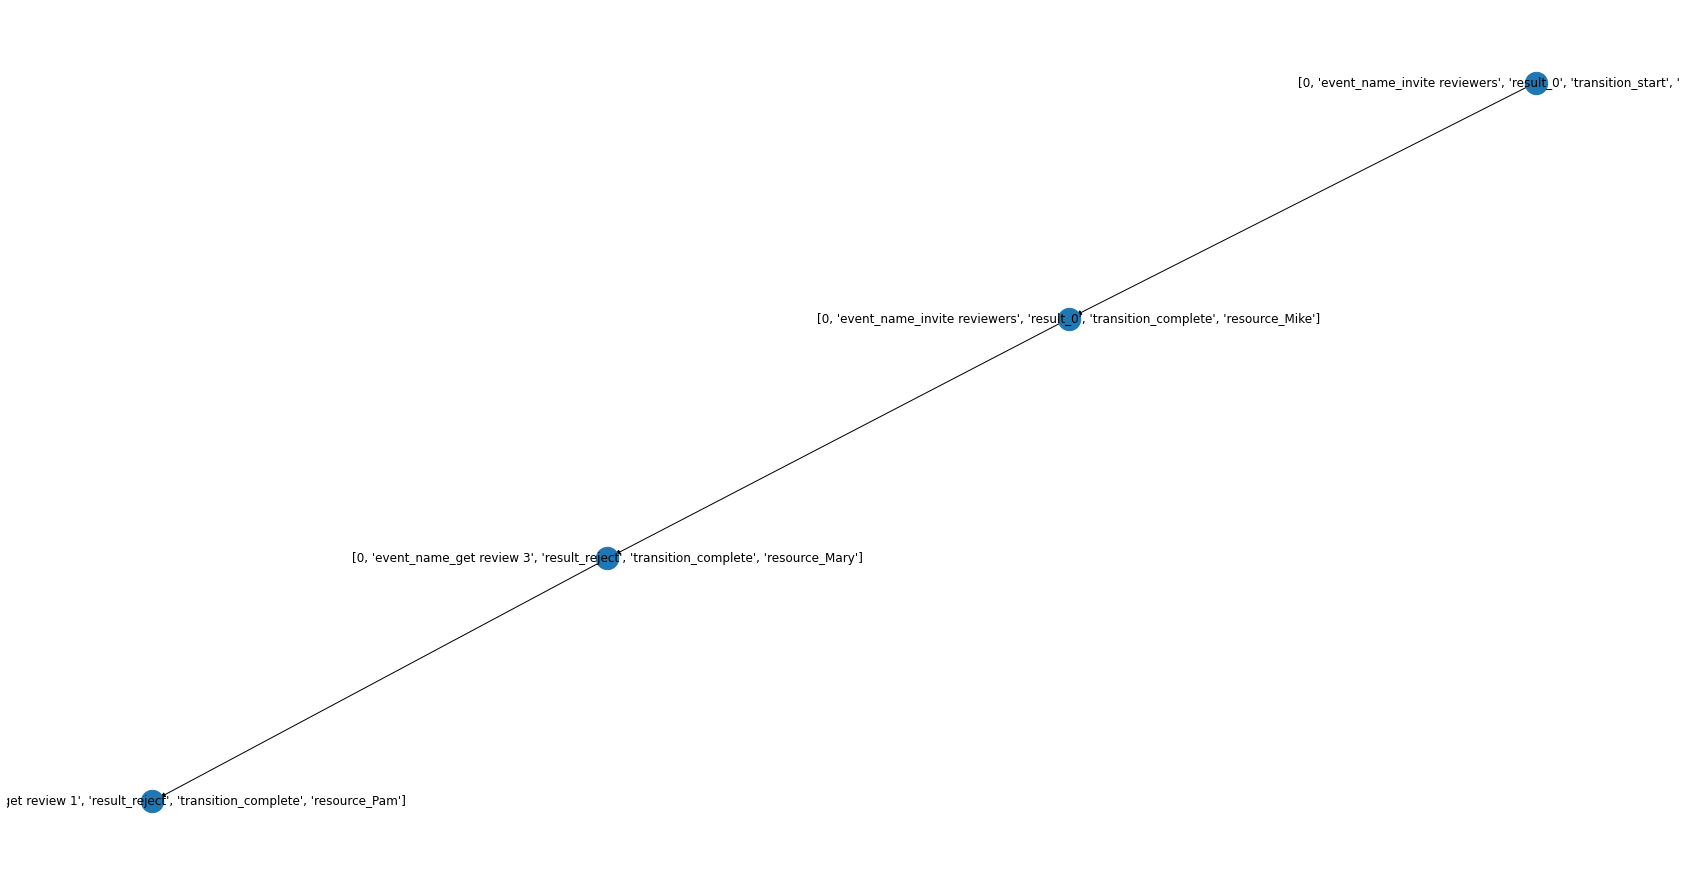

In [ ]:
from utilities_preprocessing import GraphDatasetHelper
# Namen können nur bei label encoder angezeigt werden. Die 0 an der ersten Stelle des Arrays stellt ein Füll-Wert für das Attribut time_bevor_event dar
helper = GraphDatasetHelper(data, node_feature = feature_data)
helper.visualise_event_based(1)

In [ ]:
# Visualisierung eines ganzen Instanz-Graphen 
data = dataset_list[0][7]
feature_data = feature_encoded_dict[0]

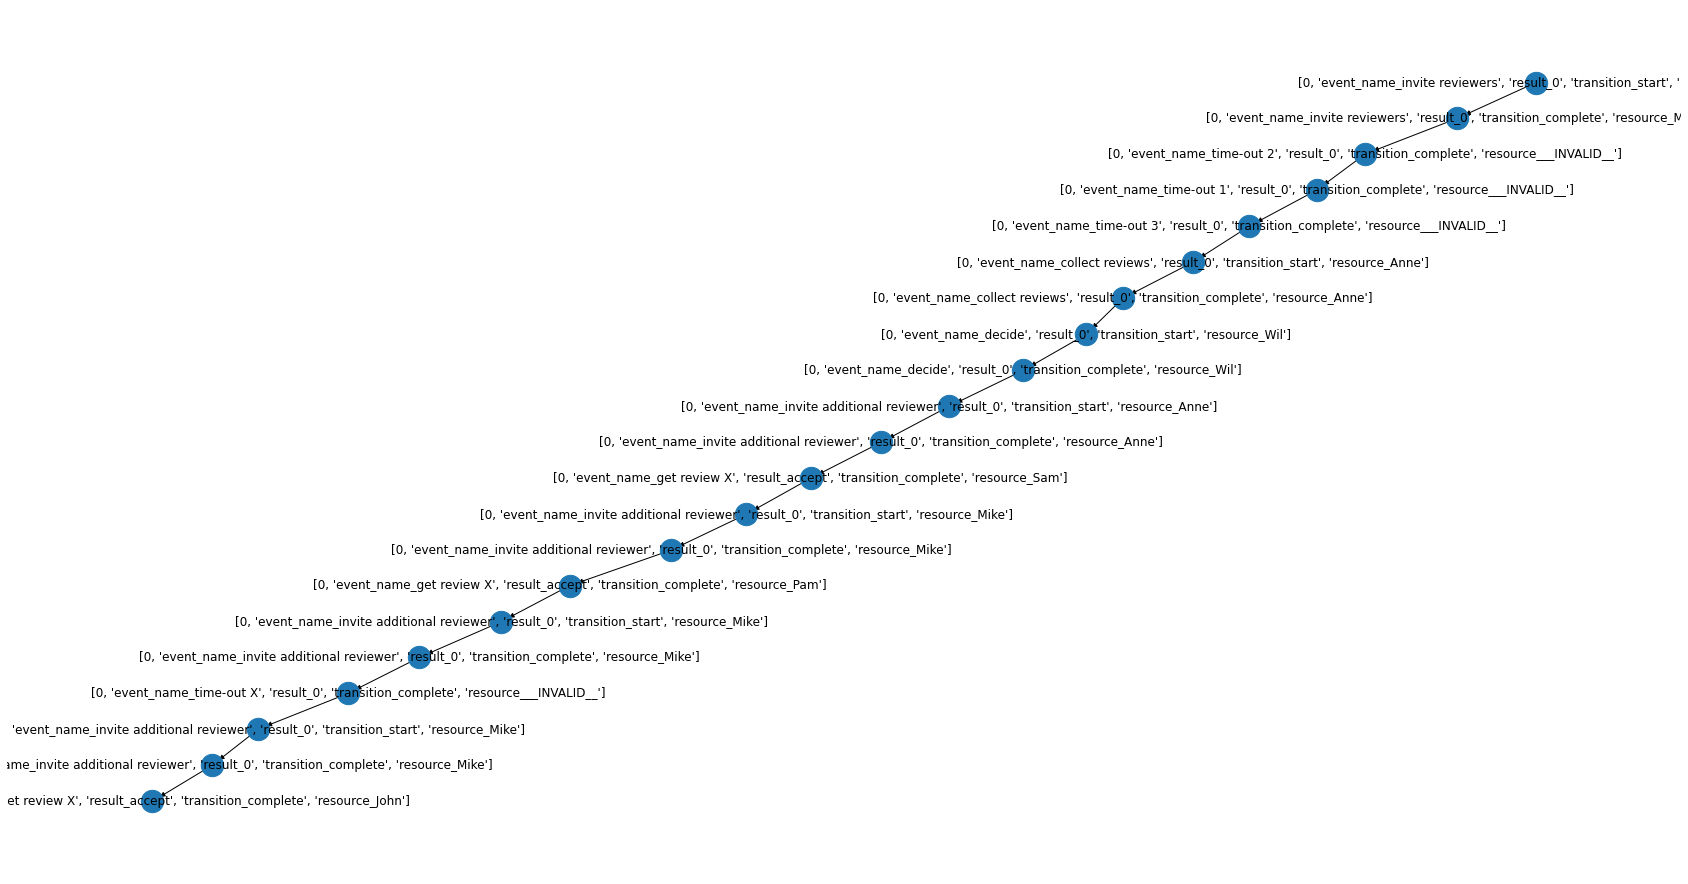

In [ ]:
helper = GraphDatasetHelper(data, node_feature = feature_data)
helper.visualise_event_based(1)

### Datensatz speichern

Speicherformat: **datensatzname_startknoten_featureanzahl_encoding**

In [ ]:
dataset_name = "review_all_events_f5_ohe_2_prefix"

In [ ]:
len(feature_encoded_dict[4])

23

In [ ]:
import joblib

In [ ]:

# Datensatz speichern
torch.save(dataset_dict, path / str("datasets/dataset_" + dataset_name) )
# Labelencoder speicher 
joblib.dump(feature_encoded_dict, "datasets/encoder_" + dataset_name + ".joblib")

['datasets/encoder_review_all_events_f5_ohe_2_prefix.joblib']

In [ ]:
feature_encoded_dict = joblib.load("datasets/encoder_" + dataset_name + ".joblib")

In [ ]:
dataset_list = torch.load( path / str("datasets/dataset_" + dataset_name))

## Log Analyse

In [ ]:
# gz unpack:
# import gzip
# import shutil
# with gzip.open(file_path +".gz", 'rb') as f_in:
#     with open(file_path, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

### Prozess-Analyse

Im Folgenden wird analysiert wie der Prozess aus einer globalen Sicht (unter einbezug des gesammten Logs) aufgebaut ist. Hierzu wird das Package pm4py verwendet. Es wird ein Verständnis über die Funktion der einzelnen Events im Prozess geschaffen.

### BPMN

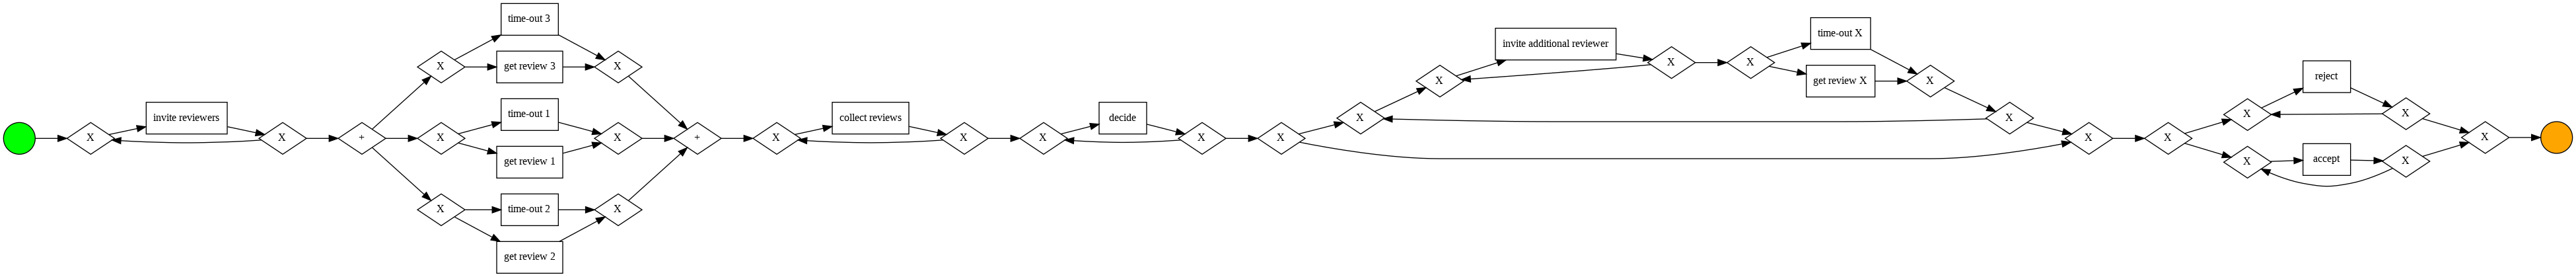

In [ ]:
  process_model = pm4py.discover_bpmn_inductive(log_review)
  pm4py.view_bpmn(process_model)

### Directly Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

https://pm4py.fit.fraunhofer.de/documentation#evaluation



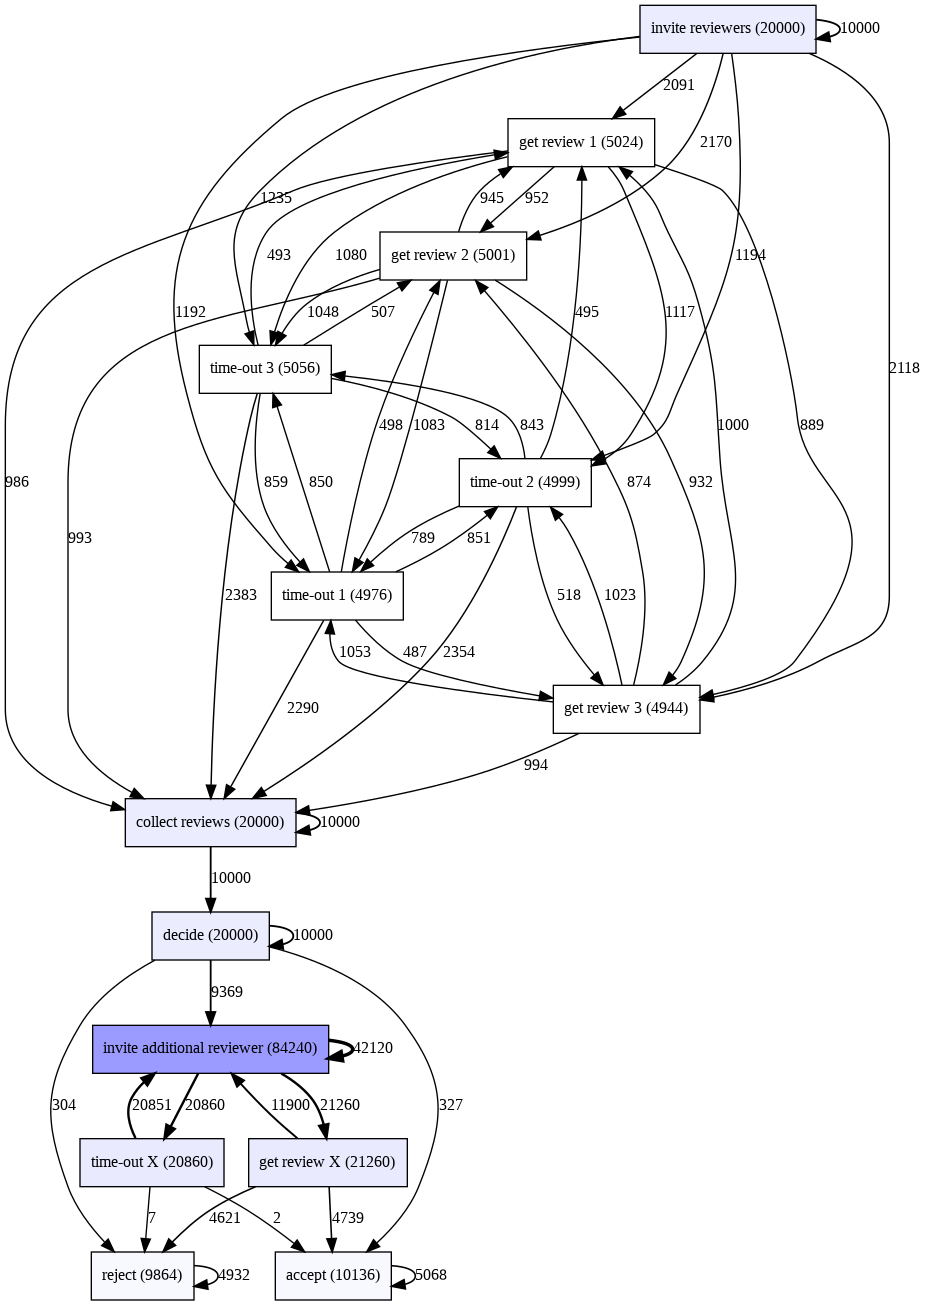

In [ ]:
from pm4py.algo.discovery.dfg import algorithm  as dfg_factory
from pm4py.visualization.dfg import visualizer  as dfg_vis_factory

dfg = dfg_factory.apply(log_review)
gviz = dfg_vis_factory.apply(dfg, log=log_review)
dfg_vis_factory.view(gviz)